## **Decision Trees**


### **About the Dataset**

The Employee Attrition dataset is composed of synthetic data from https://www.kaggle.com/datasets/patelprashant/employee-attrition/data. There are 35 features (work environment, job roles, salaries, work-life balance, overall satisfaction, etc.) in these CSV file and 1400 rows of data that can be used to describe and predict the class label of the employee 'Attrition', which is 'Yes' or 'No', meaning if the employee has stayed in the company or left.

One of the biggest challenges companies face is retaining top talent. Employee attrition (when employees leave the company) can be costly, both in terms of productivity and recruitment expenses. By applying a Decision Tree Classifier, my goal is to identify patterns in employee data that predict whether an employee is likely to leave or stay. The model will aim to help HR professionals understand what drives employee retention and how to reduce attrition in the organization. 

I'll explore:
* Which factors are most important in predicting employee attrition.
* How decision trees can be used to classify employees based on their likelihood of staying.
* How HR teams can use this model to make data-driven decisions to improve retention strategies.

In [1]:
# import the libraries
#!pip install graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log2
from sklearn import tree
import graphviz
import seaborn as sns
sns.set_style('darkgrid')

## **Load Data**

In this step, we load the dataset and view the first few rows to ensure proper loading.
We'll use pandas to read the CSV file and display the first few rows of the dataset.

In [2]:
# Import and view dataset
df = pd.read_csv('files/employee_attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

### **Exploratory Data Analysis**

In [4]:
# Explore distribution of target feature
df['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [5]:
1233/(1233+237)

0.8387755102040816

There is a large class imbalance in the dataset, since 83% of the dataset is represented by 'No' attrition data. This could cause problems for any model that is implemented because with fewer 'Yes' data points to train on, the model will the model will not perform well when predicting the minority ('Yes') class. This leads to bias in the model, as it favors the majority class. One way we can balance the classes is to resample the data set, or removing enough rows from the majority class to be of sizeable comparison to the minority class.

Text(0.5, 1.0, 'Distribution of Job Satisfaction')

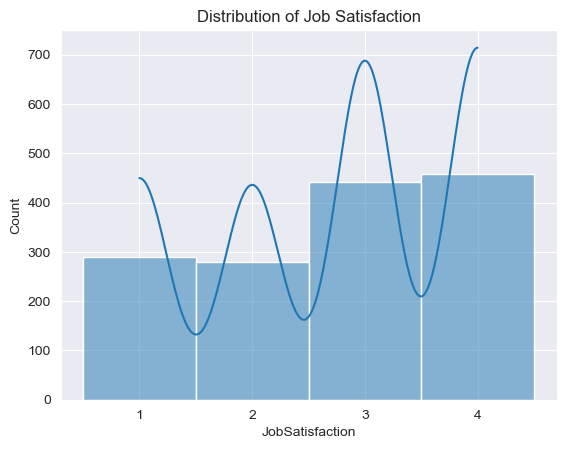

In [6]:
# Visualize JobSatisfaction
sns.histplot(data=df['JobSatisfaction'], kde=True, discrete=True)
plt.xticks([1,2,3,4])
plt.title('Distribution of Job Satisfaction')

Text(0.5, 1.0, 'Distribution of Years at Company')

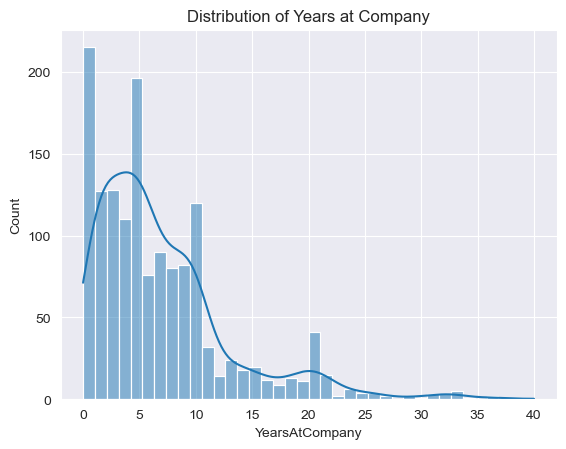

In [7]:
# Visualize YearsAtCompany
sns.histplot(data=df['YearsAtCompany'], kde=True)
plt.title('Distribution of Years at Company')

### **Feature Engineering**

Separate features and target into different dataframes

In [8]:
# Extract feature columns
df_features = df.drop(columns=['Attrition'])
df_features.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,1,80,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,4,80,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,2,80,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,3,80,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,4,80,1,6,3,3,2,2,2,2


In [9]:
# Extract target column
df_target = df['Attrition']
df_target.head()

0    Yes
1     No
2    Yes
3     No
4     No
Name: Attrition, dtype: object

Store categorical data in new dataframe


In [10]:
# Using list comprehension and select_dtypes to find categorical columns
categorical_cols = df_features.select_dtypes(exclude=[np.number]).columns.to_list()

# Make new df with only categorical variables
categorical_variables = df[categorical_cols]
categorical_variables

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
...,...,...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No
1466,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,Y,No
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Y,Yes
1468,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,Y,No


Split data into training and testing sets

In [11]:
from sklearn.model_selection import train_test_split

# Reduce dimension in target variable
df_target = np.squeeze(df_target)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target)

In [12]:
print(f'X_train: {X_train.shape} \nX_test: {X_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')

X_train: (1102, 34) 
X_test: (368, 34) 
y_train: (1102,) 
y_test: (368,)


### **Build decision tree**

In [13]:
# Encode categorical variables for features (1=True, 0=False)
encoded_categorical = pd.get_dummies(X_train[categorical_cols], drop_first=True, dtype=int)

# Drop categorical columns
X_train = X_train.drop(columns=categorical_cols)

# Add encoded categorical columns
X_train_encoded = pd.concat([X_train, encoded_categorical], axis=1)

# Preview dataframe
X_train_encoded.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
193,43,1344,7,3,1,262,4,37,4,1,...,0,0,0,0,1,0,0,0,0,0
91,51,632,21,4,1,120,3,71,3,2,...,0,0,0,0,0,1,0,0,1,1
428,47,983,2,2,1,574,1,65,3,2,...,0,0,1,0,0,0,0,0,0,0
625,45,930,9,3,1,864,4,74,3,3,...,0,0,0,0,0,1,0,0,0,1
13,34,1346,19,2,1,18,2,93,3,1,...,1,0,0,0,0,0,0,0,0,0


In [14]:
# Encode y_train into integers (yes, no --> 1, 0)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [15]:
# Inititalize decision tree
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)

# Fit model
clf.fit(X_train_encoded, y_train_encoded)

DecisionTreeClassifier(max_depth=3)

### **Visualize the Tree**

In [22]:
import os

# Explicitly add Graphviz bin directory to PATH
graphviz_bin_path = r'C:\Program Files\Graphviz\bin'
os.environ['PATH'] = graphviz_bin_path + os.pathsep + os.environ.get('PATH', '')

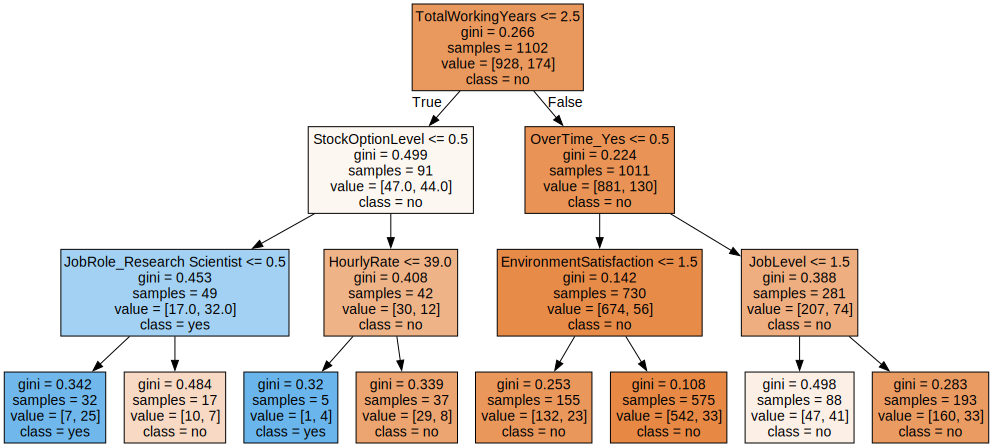

In [23]:
# Get data
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X_train_encoded.columns, class_names=['no', 'yes'], filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format='png')
graph

### **Make predictions**

Preprocess the test dataset

In [18]:
# Encode categorical variables for features (1=True, 0=False)
new_encoded_categorical = pd.get_dummies(X_test[categorical_cols], drop_first=True, dtype=int)

# Drop categorical columns
X_test = X_test.drop(columns=categorical_cols)

# Add encoded categorical columns
X_test_encoded = pd.concat([X_test, new_encoded_categorical], axis=1)

# Preview dataframe
X_test_encoded.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
451,42,319,24,3,1,605,4,56,3,3,...,0,0,1,0,0,0,0,1,0,1
1068,28,289,2,2,1,1504,3,38,2,1,...,1,0,0,0,0,0,0,0,1,0
806,52,994,7,4,1,1118,2,87,3,3,...,0,0,0,0,0,0,0,0,1,0
1404,42,335,23,2,1,1976,4,37,2,2,...,0,0,0,0,1,0,0,0,1,0
651,47,249,2,2,1,903,3,35,3,2,...,0,0,0,0,0,1,0,1,0,1


Extract a sample from the testing data, make a prediction, and visualize the prediction path

In [19]:
# Extract a random data instance from df_test
import random

random_instance_index = random.randint(0, len(X_test_encoded) - 1)
random_instance = X_test_encoded.iloc[random_instance_index, :]

# Visualize the prediction node path
node_indicator = clf.decision_path(X_test_encoded.iloc[[random_instance_index]])

# Get the indices of the nodes visited along the decision path
node_indices = node_indicator.indices

# Extract the node names and conditions for the decision path
decision_path_info = []

for node_index in node_indices:
    # Get the feature index used at this node
    feature_index = clf.tree_.feature[node_index]

    if feature_index != -2:  # Check if it's not a leaf node (-2 represents leaf nodes)
        # Get the feature name and threshold (condition) used at this node
        feature_name = X_test_encoded.columns[feature_index]  # Get feature name of node
        threshold = clf.tree_.threshold[node_index]           # Get threshold used at node
        condition = f'{feature_name} <= {threshold:.2f}'      # Define condition at node
        decision_path_info.append((node_index, feature_name, condition)) # Add info

# Print the extracted decision path information
for node_index, feature_name, condition in decision_path_info:
    print(f"Node {node_index}: {condition}")

Node 0: TotalWorkingYears <= 2.50
Node 8: OverTime_Yes <= 0.50
Node 9: EnvironmentSatisfaction <= 1.50


Get the predicted result and assess the accuracy


In [20]:
# Make predictions
y_pred = clf.predict(X_test_encoded)

# Encode to match formatting
y_test_encoded = le.transform(y_test)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_encoded, y_pred)
accuracy

0.8288043478260869

Visualize decision tree performance with a confusion matrix

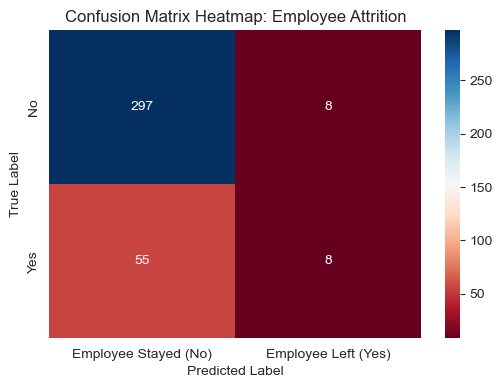

In [21]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(data=cm, annot=True, fmt='d', cmap='RdBu',
            xticklabels=['Employee Stayed (No)', 'Employee Left (Yes)'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap: Employee Attrition")
plt.show()

The accuracy score can mask a class imbalance because the model has high accuracy for the majority class. In contrast, a confusion matrix exposes the class imbalance and low accuracy for the minority class. There is a greater number of false positives (59) than false negatives (3), but there is a much greater proportion of false negatives to true negatives than there is false positives to true positives. This indicates that the model has class bias and struggles to predict the 'Yes' class.

To improve the model, the class imbalance needs to be addressed. You can do this by resampling (specifically, removing rows from the majority class), generating synthetic data for the minority class, or using sklearn's BalancedBaggingClassifier.

### **Final Thoughts**

**Decision Tree:** Due to the class imbalance, most of the predictors lead to 'No' employee attrition. The strongest predictor seems to be MonthlyIncome <= 2779.5 because it is the root node. The one instance of the tree predicting 'Yes' for employee attrition is when MonthlyIncome <= 2779.5 is True -- thus, lower income is an important potential predictor of employee attrition. Furthermore, if employees do not have overtime opportunities and have less than 0.5 years with their current manager, then employee attrition ('Yes') is predicted to be more likely.

**Feature Engineering:** The feature engineering undertaken for this dataset was encoding the categorical variables as binary variables, allowing the model to utilize all of the features. For example, EducationField was split up into different columns like EducationField_Medical and EducationField_LifeSciences. By including the categorical variables, the model had more features to make predictions with, which potentially improved model performance.

**Model Suitability:** A decision tree is an appropriate model for predicting employee attrition. It is a classification method, which can predict categorical targets like Attrition (yes or no). It is an efficient method that does not require intense computational power. A decision tree is also highly interpretable because you can follow the path of decisions to each leaf node. For example, from the decision tree visualization, we can identify YearsWithCurrentManager <= 0.5, along with the previous parent nodes, as being a predictor of 'Yes' (employee attrition).

**Business Implications** As stated in the introduction of this file, employee attrition is expensive for businesses. Depending on the context, high employee attrition could be a sign of poor working conditions or unsatisfactory outcomes, challenges that ultimately harm both businesses and employees. If data science can help inform businesses of why employees leave, then leaders can make decisions that address the reasons employees leave as well as maintain the conditions that attract/keep employees. For example, this analysis shows that higher job satisfaction (which has the lowest Gini Indexes) is a strong predictor of employees staying. Using this information, management can investigate what leads to job satisfaction and take steps to ensure job satisfaction in the future.